<a href="https://colab.research.google.com/github/mwhite270/Gold_Crypto_Forecasting/blob/main/Gold_and_Crypto_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GOLD AND CRYPTO FORECASTING**

*   Observe price trends of gold, bitcoin, and ethereum
*   Use python time series forecasting and statistical models
*   Compare trends and forecasts
of coin pricing

Data sourced from coingecko.com

Notebook developed in Google Colab.



# Install and import packages

In [3]:
!pip install statsforecast utilsforecast --quiet

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive
from statsforecast.models import AutoARIMA

import warnings
warnings.filterwarnings("ignore")

# Data loading

Pricing data comes from coingecko. For consistency purposes.
>"Tether Gold" coin is used instead of actual gold trading price. The prices are comparable, per Tether Gold's design.

In [5]:
# https://www.coingecko.com/en/coins/tether-gold

# gold_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/Price_Forecasting/tethergold-usd-max.csv", parse_dates=["snapped_at"]) # Update this to your folder
gold_df = pd.read_csv("/content/Data/tethergold-usd-max.csv", parse_dates=["snapped_at"]) # Use this if available. (Google Colab deletes after a runtime ends)
gold_df.head()

,snapped_at,price,market_cap,total_volume
0,2020-01-26 00:00:00+00:00,1575.958260,0.000000e+00,3.035078e+04
1,2020-01-27 00:00:00+00:00,1585.137326,6.324698e+06,1.031043e+06
2,2020-01-28 00:00:00+00:00,1576.757639,6.299489e+06,1.182152e+06
3,2020-01-29 00:00:00+00:00,1588.063769,6.328189e+06,2.156086e+06
4,2020-01-30 00:00:00+00:00,1566.679964,6.279659e+06,4.101913e+05


In [6]:
# https://www.coingecko.com/en/coins/bitcoin

# btc_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/Price_Forecasting/btc-usd-max.csv", parse_dates=["snapped_at"])
btc_df = pd.read_csv("/content/Data/btc-usd-max.csv", parse_dates=["snapped_at"])
btc_df.head()

,snapped_at,price,market_cap,total_volume
0,2013-04-28 00:00:00+00:00,135.30,1.500518e+09,0.0
1,2013-04-29 00:00:00+00:00,141.96,1.575032e+09,0.0
2,2013-04-30 00:00:00+00:00,135.30,1.501657e+09,0.0
3,2013-05-01 00:00:00+00:00,117.00,1.298952e+09,0.0
4,2013-05-02 00:00:00+00:00,103.43,1.148668e+09,0.0


In [7]:
# https://www.coingecko.com/en/coins/ethereum

# eth_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/Price_Forecasting/eth-usd-max.csv", parse_dates=["snapped_at"])
eth_df = pd.read_csv("/content/Data/eth-usd-max.csv", parse_dates=["snapped_at"])
eth_df.head()

,snapped_at,price,market_cap,total_volume
0,2015-08-07 00:00:00+00:00,2.831620,0.000000e+00,9.062200e+04
1,2015-08-08 00:00:00+00:00,1.330750,8.033948e+07,3.680700e+05
2,2015-08-10 00:00:00+00:00,0.687586,4.155631e+07,4.004641e+05
3,2015-08-11 00:00:00+00:00,1.067379,6.453901e+07,1.518998e+06
4,2015-08-12 00:00:00+00:00,1.256613,7.601326e+07,2.073893e+06


# Prepare data to meet utilsforecast requirements

*   Create a 'unique_id' column for each coin
*   Combine into a single dataframe
*   Rename 'snapped_at' column to 'ds' to satisfy date column naming requirement
*   Rename 'price' column to 'y' to satisfy forecasting column naming requirement

In [8]:
gold_df['unique_id'] = 'gold'
btc_df['unique_id']= 'btc'
eth_df['unique_id']= 'eth'

In [9]:
df = pd.concat([gold_df, btc_df, eth_df], axis = 0) # Combining dataframes
df = df.drop(['market_cap','total_volume'], axis = 1) # Dropping unnecessary columns
df = df.rename(columns={'snapped_at': 'ds', 'price': 'y'}) # Renaming columns as required

# Using utilsforecast to plot the pricing history

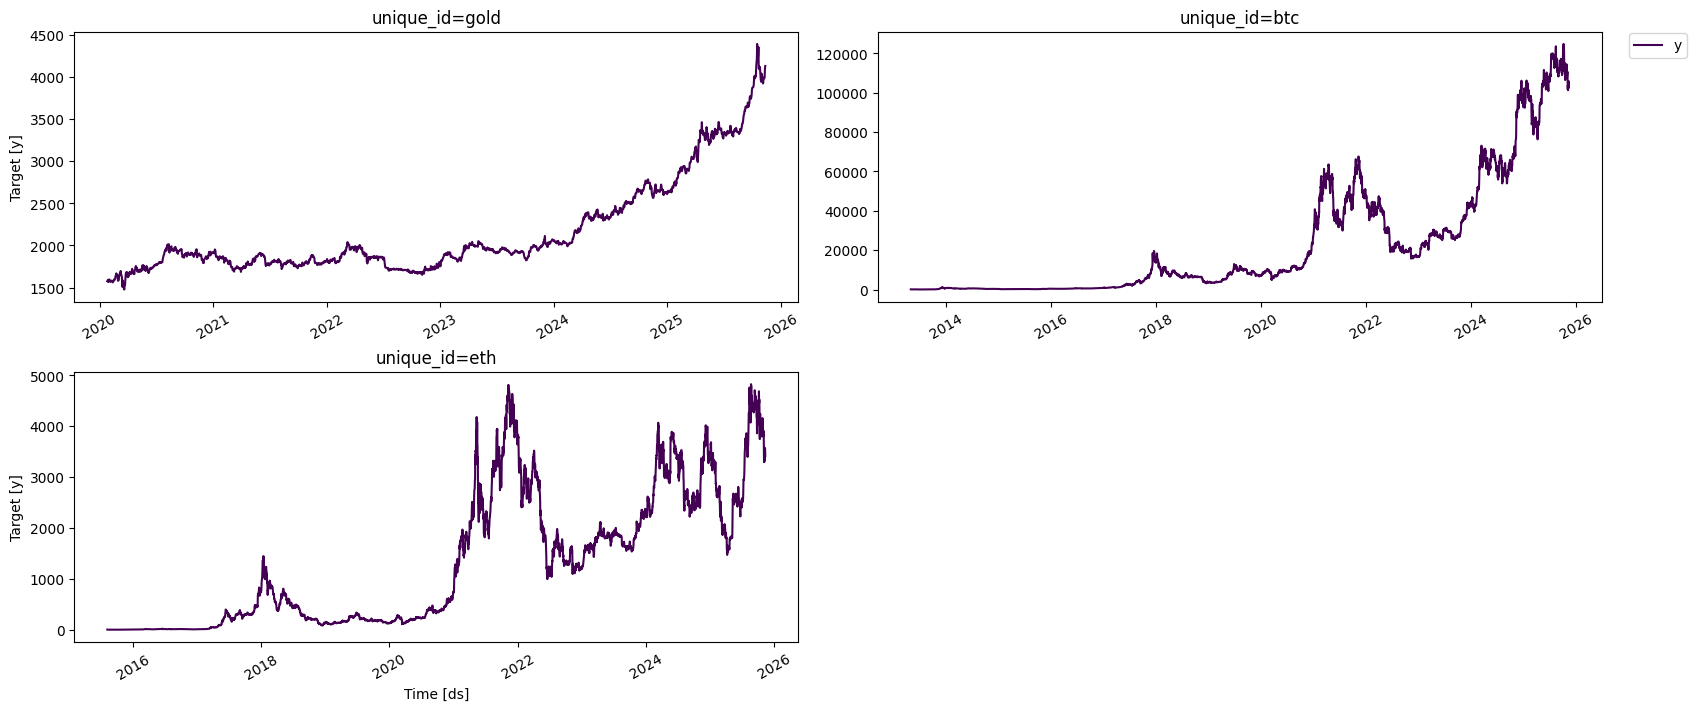

In [10]:
# Plotting
plot_series(df=df, # Dataframe needs to be specified
            ids=['gold', 'btc', 'eth'], # specifying the different plots
            palette='viridis', # pallette comes from matplotlib options
)

The price of gold is showing a relatively steady climb over time.

Bitcoin and Ethereum are showing significant seasonality peaks and valleys. This is what one would expect to see considering the volatility of the crypto market.

The pricing data is different for all  coins. This is because they were launched at different times.
> I found actual gold trading price data going as far back as the 1800s!

Moving forward, let's focus on 2020+

In [11]:
df = df[df['ds'] >= '2020-01-01'] #Selecting only 2020+ dates

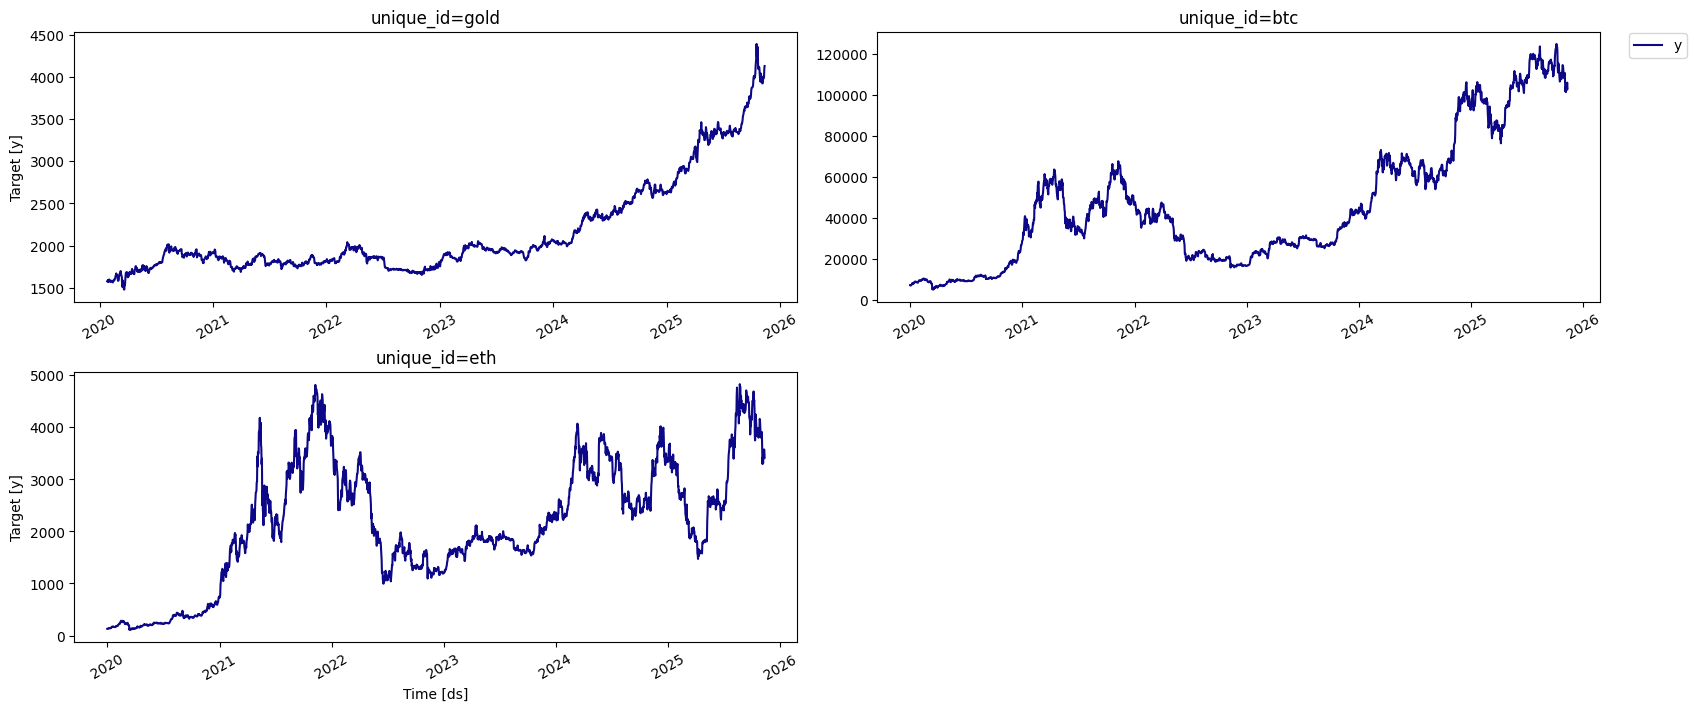

In [12]:
plot_series(df=df, ids=['gold', 'btc', 'eth'], palette='plasma')

# Making Baseline Models


Using StatsForecast built in models for comparison:
*   Naive - Based on the last timestep
*   Historic Average - Uses historical average of the day
*   Window Average - Uses average of a set window
*   Seasonal Naive - Uses data of a set season length



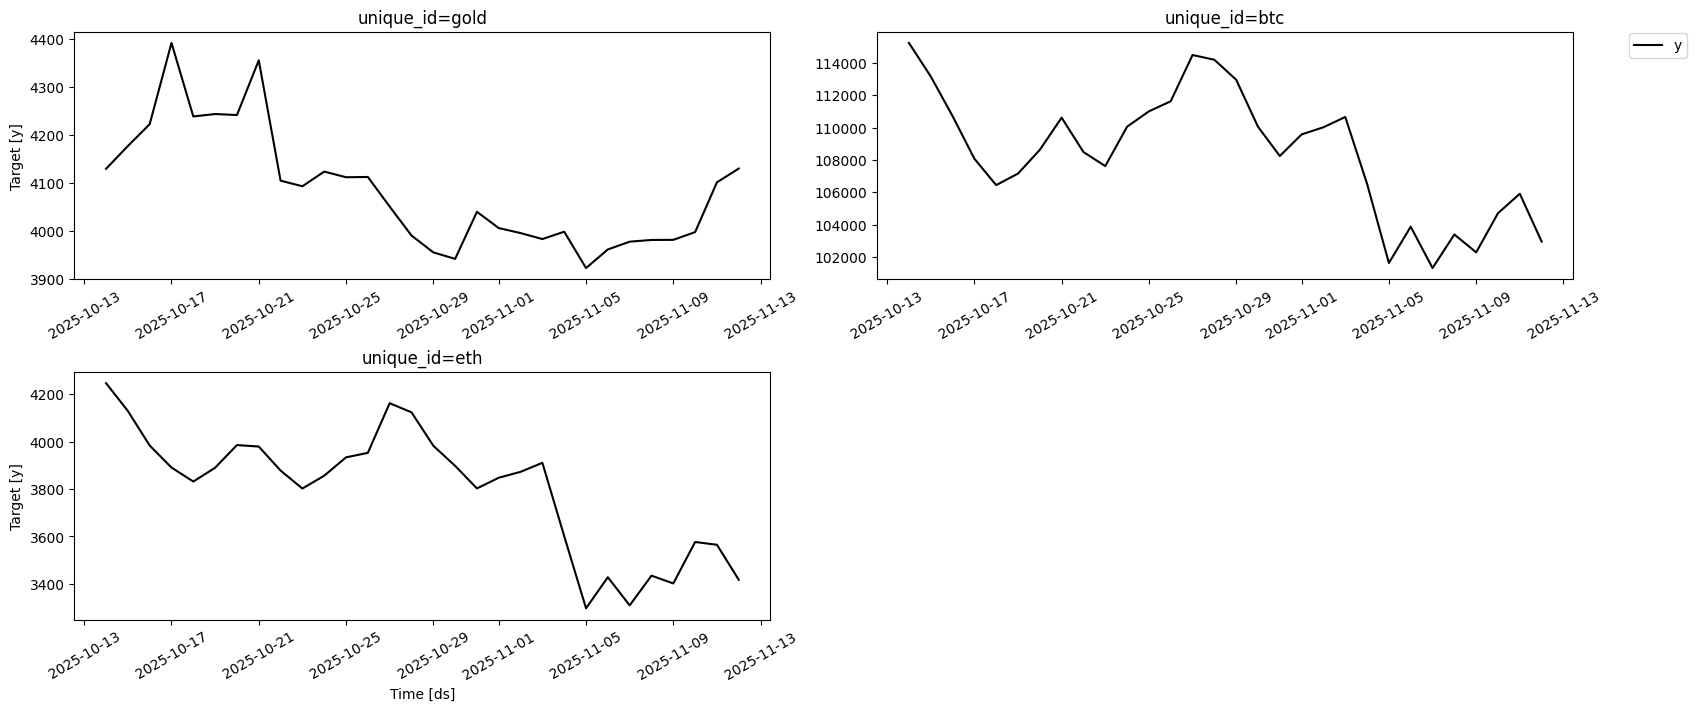

In [13]:
plot_series(df=df, max_insample_length=30, palette='inferno') #Zooming in on the last 30 days for visibility

In [14]:
horizon = 7 # Forecast/Predict the next 7 days.

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7), # 7 day window
    SeasonalNaive(season_length=7) # A season of 7 days
]

sf = StatsForecast(models=models, freq="D") # Daily frequency
sf.fit(df=df)
preds = sf.predict(h=horizon)
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,btc,2025-11-13 00:00:00+00:00,102960.775645,46194.092225,103495.192614,103877.959660
1,btc,2025-11-14 00:00:00+00:00,102960.775645,46194.092225,103495.192614,101322.640295
2,btc,2025-11-15 00:00:00+00:00,102960.775645,46194.092225,103495.192614,103396.084216
3,btc,2025-11-16 00:00:00+00:00,102960.775645,46194.092225,103495.192614,102290.137147
4,btc,2025-11-17 00:00:00+00:00,102960.775645,46194.092225,103495.192614,104709.678617


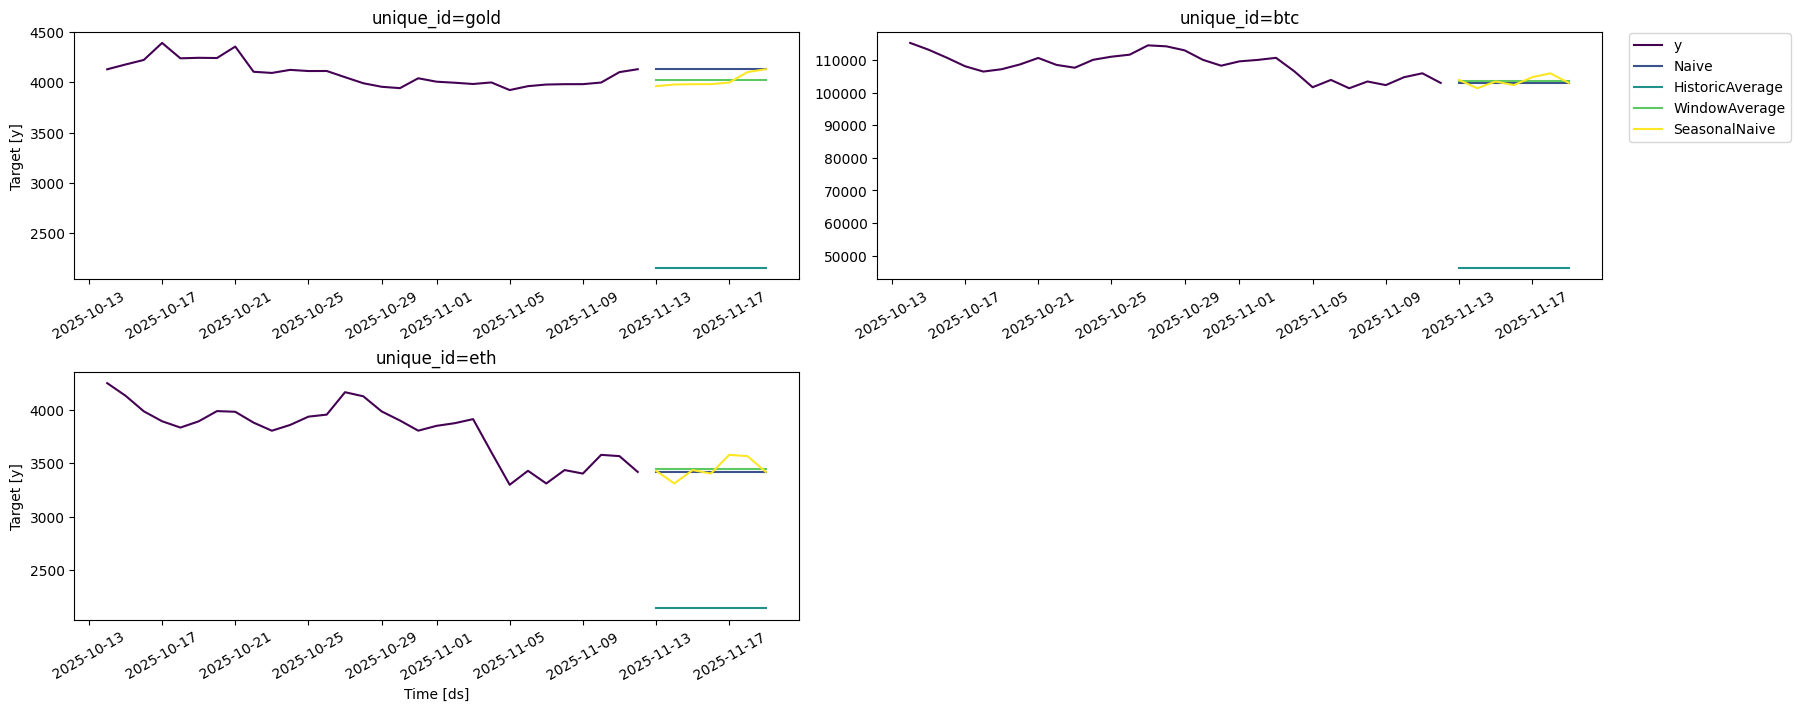

In [15]:
plot_series(df=df,forecasts_df=preds, max_insample_length=30, palette="viridis")

# Evaluating the baseline models

In [16]:
test = df.groupby("unique_id").tail(7) # Testing with the last 7 days
train = df.drop(test.index).reset_index(drop=True) # Training with everything before the last 7 days

In [17]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])

In [18]:
evaluation = evaluate(eval_df, metrics=[mae]) # MAE = Mean Absolute Error
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,btc,mae,1949.242514,57433.822105,4602.242487,4980.957237
1,eth,mae,150.408527,1309.758347,299.521818,333.818266
2,gold,mae,95.979078,1873.343014,44.426320,63.635599


What is the overall model MAE?

In [19]:
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,731.876706,20205.641155,1648.730208,1792.803701


Charting the comparisons.

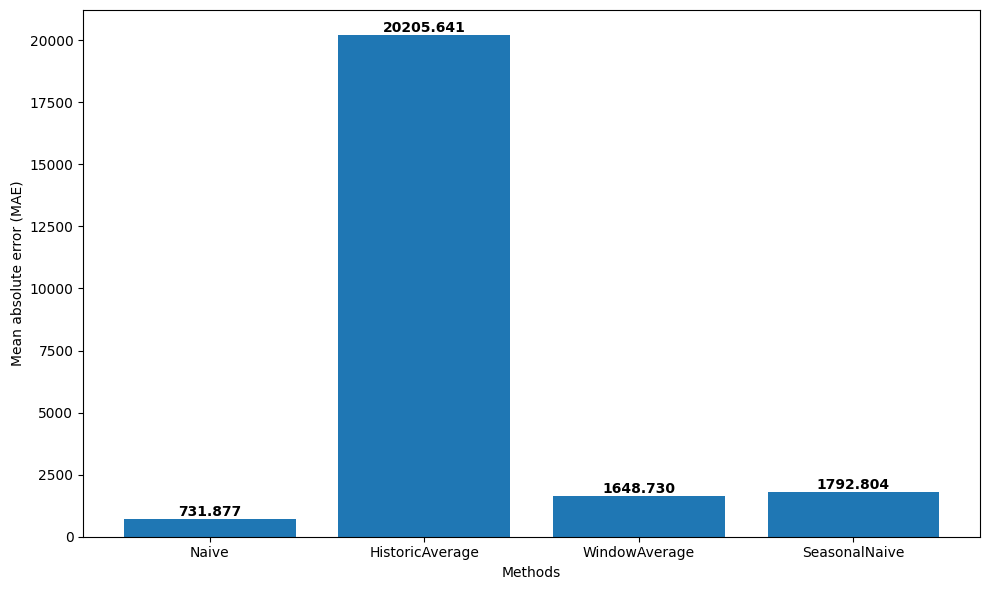

In [20]:
methods = evaluation.columns[1:].tolist()
values = evaluation.iloc[0, 1:].tolist()

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

As expected, it is difficult to have low error forecasting for gold, btc, and eth. The markets can be very volatile.

Naive, Window Average, and Seasonal Naive may be viable, but Historic Average should not be considered.

# Forecast Using Auto ARIMA Models

In [21]:
arima_train = train # Creating dataframe copies for ARIMA modeling use.
arima_test = test

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"), # ARIMA model without seasonal components
    AutoARIMA(season_length=7, alias="SARIMA") # Seasonal ARIMA
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=arima_train)
arima_preds = sf.predict(h=horizon)

In [22]:
arima_preds.tail()

,unique_id,ds,ARIMA,SARIMA
16,gold,2025-11-08 00:00:00+00:00,3939.500810,3935.283954
17,gold,2025-11-09 00:00:00+00:00,3943.283353,3938.634006
18,gold,2025-11-10 00:00:00+00:00,3947.068763,3937.718847
19,gold,2025-11-11 00:00:00+00:00,3950.853956,3936.354839
20,gold,2025-11-12 00:00:00+00:00,3954.639164,3938.488858


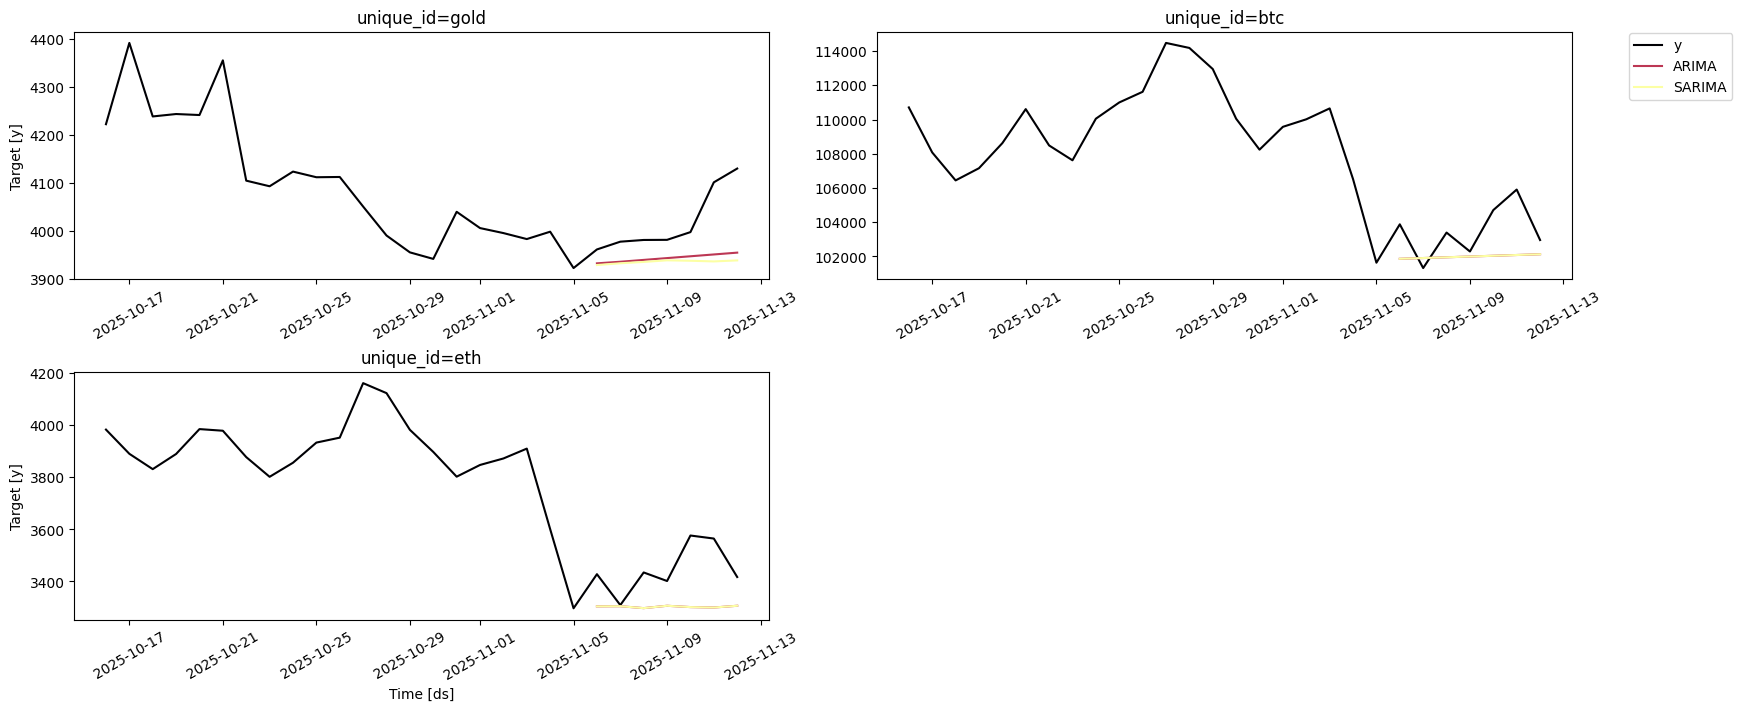

In [23]:
plot_series(df=df,forecasts_df=arima_preds, max_insample_length=28, palette = 'inferno')

ARIMA and Seasonal ARIMA show similar predictions. How do they compare to the base models?

In [24]:
# eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])
arima_eval_df = pd.merge(arima_test, arima_preds, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(arima_eval_df, metrics=[mae]) # Evaluate for each coin
arima_eval

,unique_id,metric,ARIMA,SARIMA
0,btc,mae,1665.889802,1665.889802
1,eth,mae,144.321427,144.321427
2,gold,mae,75.157654,83.101021


In [25]:
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index() #Overall MAE
arima_eval

,metric,ARIMA,SARIMA
0,mae,628.456294,631.104083


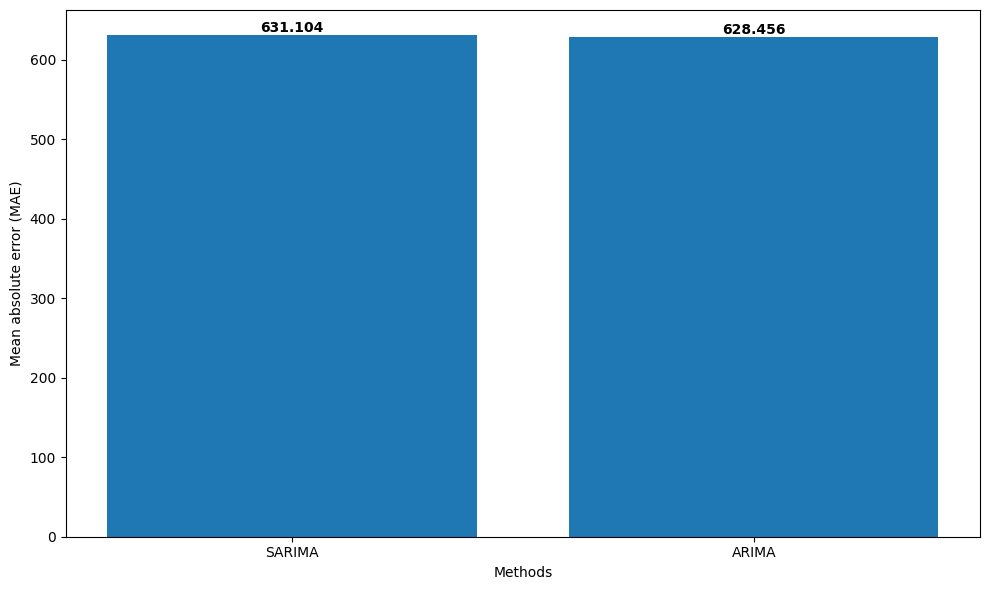

In [26]:
methods = arima_eval.columns[1:].tolist()
values = arima_eval.iloc[0, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

Naive, ARIMA, and SARIMA have similar error.

Let's do cross validation on these 3 models.

# Cross-Validation of Models



*   Naive
*   ARIMA
*   Seasonal ARIMA



In [27]:
models = [
    Naive(),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
cv_df = sf.cross_validation(
    h=horizon, # 7 days
    df=df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_df.head()

,unique_id,ds,cutoff,y,Naive,ARIMA,SARIMA
0,btc,2025-09-18 00:00:00+00:00,2025-09-17 00:00:00+00:00,116455.946482,116762.849686,116745.815901,116745.815901
1,btc,2025-09-19 00:00:00+00:00,2025-09-17 00:00:00+00:00,117145.495090,116762.849686,116802.026004,116802.026004
2,btc,2025-09-20 00:00:00+00:00,2025-09-17 00:00:00+00:00,115655.810464,116762.849686,116854.356064,116854.356064
3,btc,2025-09-21 00:00:00+00:00,2025-09-17 00:00:00+00:00,115715.515368,116762.849686,116906.891666,116906.891666
4,btc,2025-09-22 00:00:00+00:00,2025-09-17 00:00:00+00:00,115304.479994,116762.849686,116959.416380,116959.416380


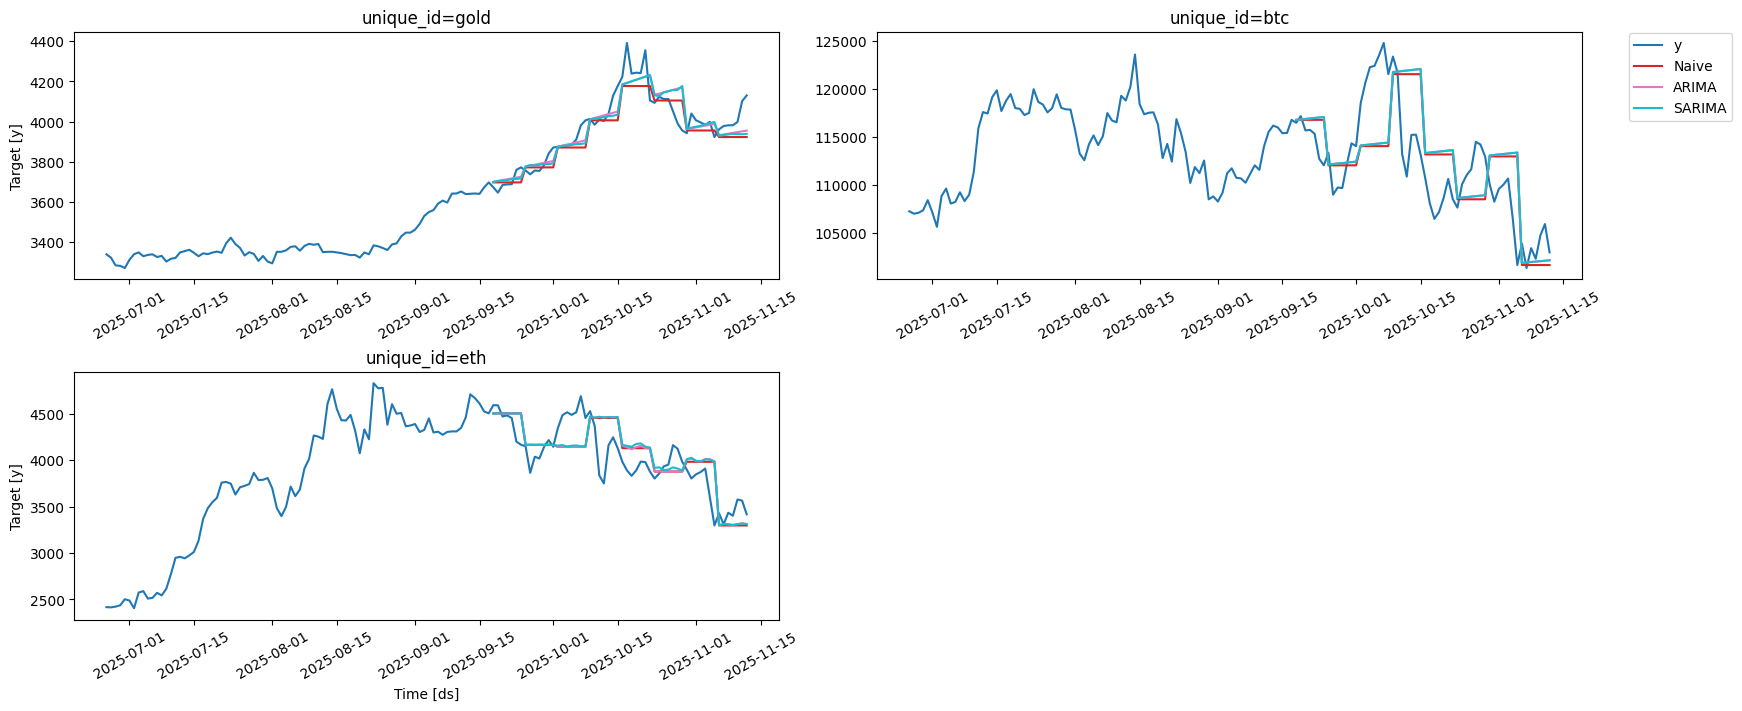

In [28]:
plot_series(
    df=df,
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),
    max_insample_length=140)

In [29]:
cv_eval = evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_eval

,metric,Naive,ARIMA,SARIMA
0,mae,1442.894688,1449.459107,1450.253976


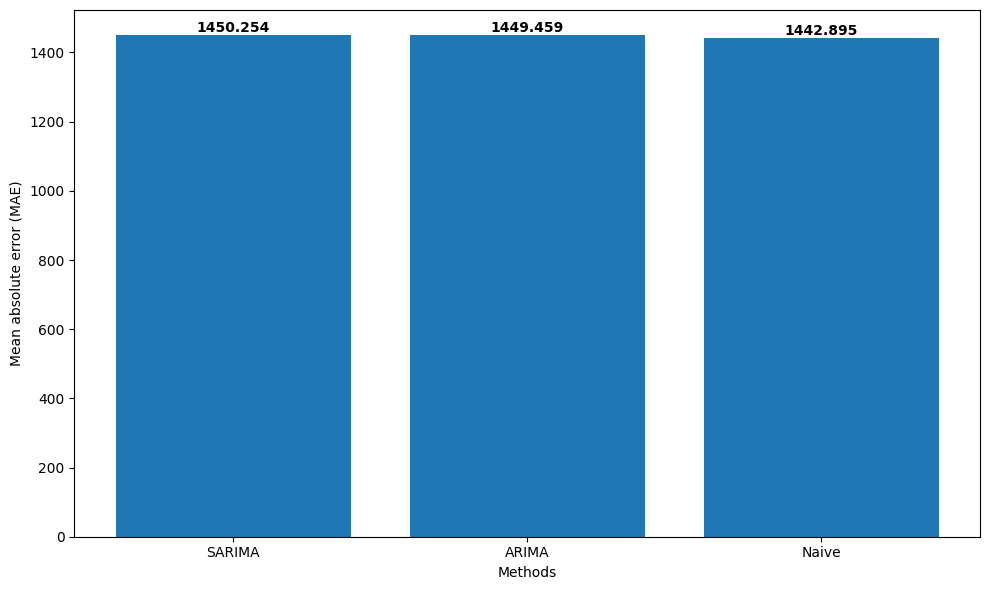

In [30]:
methods = cv_eval.columns[1:].tolist()
values = cv_eval.iloc[0, 1:].tolist()

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

Cross validation shows a similar error for all 3 models. With all having a high degree of prediction error. This makes sense considering the markets can be very volatile. **Predicting them is difficult!**

If one were to be recommended, it would be **<u>Naive</u>**. This is because running AutoARIMA is quite slow in comparison, and with slighly more error.